For my final project, I used the Pima Indians dataset from Kaggle/UCI Machine learning repository. 

The Pima native Americans have high rates of diabetes. In this dataset, there are 768 women with 8 characteristics 

Can we predict the presence or absence of diabetes (diagnosed 1-5 years after the measured timepoint) using these variables as features? 


In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

diabetes = pd.read_csv('/Users/mirabajaj/Downloads/diabetes.csv')

Outcome
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

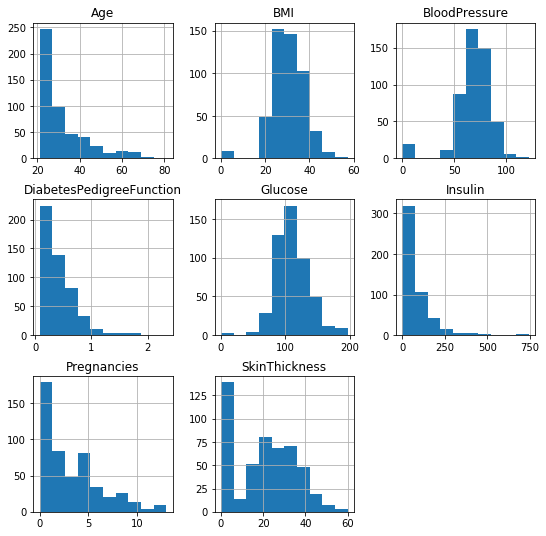

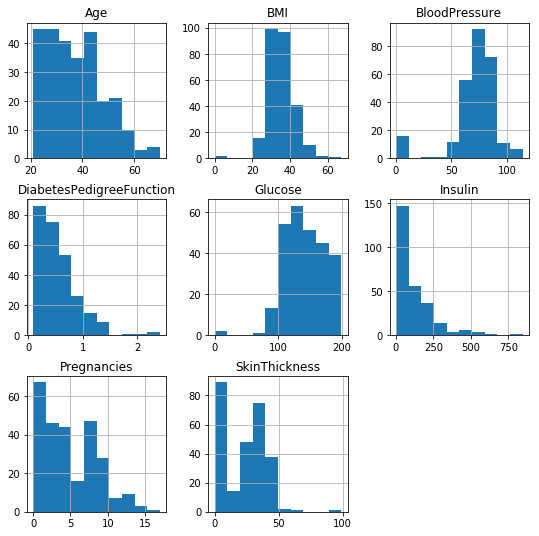

In [2]:
diabetes.groupby('Outcome').hist(figsize=(9, 9))

In [3]:
diabetes.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


It seems like there are missing values coded as 0. So, we will replace them with null. 

In [4]:
diabetes[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [5]:
diabetes.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

For the features where there are only a few missing, we can drop the rows. For the features where half of the values are missing, we can drop those features (at the end I try imputing them, but it lowers accuracy)

In [6]:
diabetes_clean = diabetes[diabetes['Glucose'].notnull() & diabetes['BloodPressure'].notnull() & diabetes['BMI'].notnull()]
diabetes_clean = diabetes_clean.drop(columns=['SkinThickness',"Insulin"])

In [7]:
diabetes_clean.shape
diabetes_clean.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Next, we will scale and split the data 

In [8]:
X = diabetes_clean.drop(columns=["Outcome"])
y = diabetes_clean["Outcome"]

from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10,stratify=y)

diabetes_clean.Outcome.value_counts()
y_test.value_counts()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0    95
1    50
Name: Outcome, dtype: int64

Then I  try a series of classification models: 
    1) Logistic Regression 
    2) Randomm Forest
    3) Decision Tree
    4) SVC 
    5) KNN

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
# from sklearn.metrics import f1_score, precision_score

#model=LogisticRegression(random_state = 10)
#model.fit(X_train, y_train)

lr = LogisticRegression(solver='liblinear')

rskf = RepeatedStratifiedKFold(n_splits=5,random_state=10, n_repeats=10)

scores = cross_val_score(lr, X_scaled, y, scoring='accuracy', cv=rskf)


In [10]:
scores

array([0.75862069, 0.77931034, 0.79310345, 0.75862069, 0.79166667,
       0.8       , 0.74482759, 0.76551724, 0.80689655, 0.75694444,
       0.76551724, 0.79310345, 0.7862069 , 0.75172414, 0.79166667,
       0.77931034, 0.77241379, 0.72413793, 0.77241379, 0.84027778,
       0.72413793, 0.80689655, 0.76551724, 0.8       , 0.79166667,
       0.75862069, 0.75172414, 0.73793103, 0.80689655, 0.80555556,
       0.77241379, 0.74482759, 0.75862069, 0.80689655, 0.77083333,
       0.80689655, 0.7862069 , 0.73103448, 0.77241379, 0.78472222,
       0.79310345, 0.7862069 , 0.79310345, 0.75172414, 0.77083333,
       0.7862069 , 0.80689655, 0.75172414, 0.77241379, 0.75694444])

In [11]:
model=LogisticRegression(random_state = 10)
model.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
y_pred=model.predict(X_test)
y_score=model.predict_proba(X_test)[:,1]
acc=metrics.accuracy_score(y_test, y_pred)
print(acc*100)

79.3103448275862


In [13]:
conf_mat = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix: LogReg\n', conf_mat)

Confusion matrix: LogReg
 [[84 11]
 [19 31]]


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators = 160, random_state=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7517241379310344


In [15]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7862068965517242


In [16]:
from sklearn.svm import SVC

svc = SVC(gamma='auto', kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8


In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
import pprint


nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6551724137931034


For KNN, let's hyperparamaterize the number of neighbors. 

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# CV iterators
inner_cv_iterator = ShuffleSplit(n_splits=5, random_state=10)
outer_cv_iterator = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Hyperparameter optimization:

# (Hyper)parameter grid
p_grid = {
    "n_neighbors": np.arange(1,50)
}

knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
g = GridSearchCV(knn, p_grid, cv=cv)

g.fit(X, y)
best = g.best_params_
cv = g.cv_results_

print('GridSearch found optimal number of neighbors:', best['n_neighbors'])
#print('Mean CV test scores are:', cv['mean_test_score'])

knn = KNeighborsClassifier(n_neighbors = best['n_neighbors']) 
knn.fit(X_train, y_train)

print('Accuracy:', accuracy_score(y_test, knn.predict(X_test)))
knn_pred = knn.predict(X_test)

## predict probabilities
probs = knn.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

GridSearch found optimal number of neighbors: 44
Accuracy: 0.8413793103448276


In [19]:
conf_mat = metrics.confusion_matrix(y_true=y_test, y_pred=knn_pred)
print('Confusion matrix: KNN\n', conf_mat)



Confusion matrix: KNN
 [[86  9]
 [14 36]]


Code below prints confusion matrix in prettier form for figure 

[[86  9]
 [14 36]]


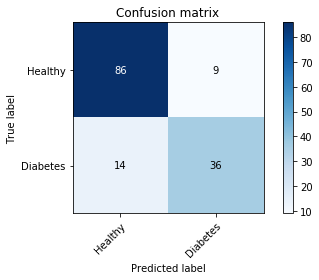

In [20]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred = knn_pred, classes = ['Healthy', 'Diabetes'],
                      title='Confusion matrix')

AUC: 0.882


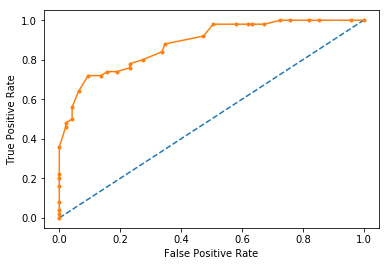

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the plot
pyplot.show()

f1=0.758 auc=0.838 ap=0.829


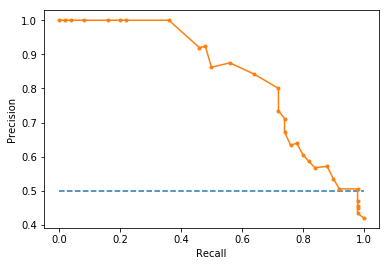

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score
# predict class values
yhat = knn.predict(X_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# calculate F1 score
f1 = f1_score(y_test, yhat)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the plot
pyplot.show()

Let's see if imputing improves the model or makes it worse. 

In [23]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
diabetes_imputed = diabetes 
diabetes_imputed['Glucose'] = imputer.fit_transform(diabetes[["Glucose"]])
diabetes_imputed['BMI'] = imputer.fit_transform(diabetes[["BMI"]])
diabetes_imputed['Insulin']  = imputer.fit_transform(diabetes[["Insulin"]])
diabetes_imputed['SkinThickness']  = imputer.fit_transform(diabetes[["SkinThickness"]])
diabetes_imputed['BloodPressure']  = imputer.fit_transform(diabetes[["BloodPressure"]])
diabetes_imputed = pd.DataFrame(diabetes_imputed)
diabetes_imputed.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [24]:
X = diabetes_imputed.drop(columns=["Outcome"])
y = diabetes_imputed["Outcome"]

from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10,stratify=y)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [25]:
# CV iterators
inner_cv_iterator = ShuffleSplit(n_splits=5, random_state=10)
outer_cv_iterator = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Hyperparameter optimization:

# (Hyper)parameter grid
p_grid = {
    "n_neighbors": np.arange(1,50)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
g = GridSearchCV(knn, p_grid, cv=cv)

g.fit(X, y)
best = g.best_params_
cv = g.cv_results_

print('GridSearch found optimal number of neighbors:', best['n_neighbors'])
print('Mean CV test scores are:', cv['mean_test_score'])

knn = KNeighborsClassifier(n_neighbors = best['n_neighbors']) 
knn.fit(X_train, y_train)

print('Accuracy:', accuracy_score(y_test, knn.predict(X_test)))
knn_pred = knn.predict(X_test)

GridSearch found optimal number of neighbors: 32
Mean CV test scores are: [0.69 0.72 0.71 0.73 0.72 0.74 0.75 0.75 0.74 0.74 0.74 0.74 0.75 0.75
 0.74 0.73 0.73 0.74 0.74 0.74 0.73 0.73 0.73 0.74 0.74 0.75 0.74 0.75
 0.74 0.75 0.74 0.75 0.74 0.74 0.75 0.75 0.74 0.74 0.74 0.74 0.74 0.74
 0.73 0.73 0.73 0.74 0.74 0.74 0.74]
Accuracy: 0.7597402597402597
